<a href="https://colab.research.google.com/github/AnnyshkaF/High-Performance-Lab/blob/main/task_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install mpi4py
!pip install pygame

# (1) Implement the game of life sequentially

In [ ]:
%pylab inline
import pygame
from random import randint
from copy import deepcopy
from numba import njit

import os
os.environ['SDL_VIDEODRIVER']='dummy'
import pygame
pygame.display.set_mode((640,480))

# the numbers according the colours
white = 0 
black = 2

died = black
empty = black
alive = white

def fillByGlider(W, H):
    GLIDER = np.array(
        [[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,],
        [0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,],
        [0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,],
        [1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,],
        [1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,],
        [0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,],
        [0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,],
        [0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,]])
    padx1, padx2, pady1, pady2 = int((W-39)/2), int((W-39)/2), int((W-9)/2), int((W-9)/2) + 1
    GLIDER = np.pad(GLIDER, ((pady1,pady2),(padx1,padx2)))
    return GLIDER

def fillFieldByRandom(life_cells, W, H):
    life_cells = int(life_cells * W * H)
    current_field = np.ones([W,H]) * 0 # fill current fied with empty cels
    counter1 = life_cells # fill field with black values
    while (counter1): # while not fill all alive cells
        x, y = randint(0, W-1), randint(0, H-1) # choose random cell
        # if this cell is empty
        if current_field[x][y] == 0:
            current_field[x][y] = 1
            counter1 -= 1
    return current_field

def fillByCondition(W, H, condition = 0, life_cells = 1.0):
    if condition == 0: filling = [[1 if not i % 9 else 0 for i in range(1,W+1)] for j in range(1,H+1)] # 2,5,8,9,10,11,13,18,21,22,26,30,33,65
    elif condition == 1: filling = [[1 if not (2 * i + j) % 4 else 0 for i in range(1,W+1)] for j in range(1,H+1)] # (2,4),(4,4)
    elif condition == 2: filling = [[1 if not (i * j) % 22 else 0 for i in range(1,W+1)] for j in range(1,H+1)] # 5,6,9,22,33
    elif condition == 3: filling = [[1 if not i % 7 else randint(0, 1) for i in range(1,W+1)] for j in range(1,H+1)]
    elif condition == 'glider' or condition == 4: filling = fillByGlider(W, H)
    elif condition == 'random' or condition == 5: filling = fillFieldByRandom(life_cells = life_cells, W = W, H = H)
    filling = np.pad(filling, ((1,1),(1,1)))
    return 2*abs(filling-1)

@njit(fastmath=True)
def check_cells(current_field, next_field, W, H):
    # fill the ghost cells to provide map's periodicity
    current_field[0, 0:H] = current_field[W-2, 0:H]
    current_field[W-1, 0:H] = current_field[1, 0:H]
    current_field[0:W, 0] = current_field[0:W, H-2] 
    current_field[0:W,H-1] = current_field[0:W, 1]
    
    for x in range(1,W+1): # go along x axis except borders
        for y in range(1,H+1): # go along y axis except borders
            
            cell_type = current_field[y][x]
            count = -1 # don't count self
            # around current cell
            for j in range(y-1,y+2):
                for i in range(x-1,x+2):
                    # increase counter if find same cell
                    if current_field[j][i] == cell_type:
                        count += 1
            
            if current_field[y][x] == alive:
                if count == 2 or count == 3:
                    next_field[y][x] = current_field[y][x] # = alive - field won't change
                else:
                    next_field[y][x] = died # cell will die
            
            if current_field[y][x] == died:                
                if count == 5:
                    next_field[y][x] = alive # cell will alive
                else:
                    next_field[y][x] = current_field[y][x] # = died
    return next_field

def gameOfLife(FPS = 10, STOP_counter = 100, CELLS =10, life_cells = 1.0, condition = 'glider'):
    W, H = CELLS, CELLS
    TILE = int(800 / CELLS)
    RES = CELLS * TILE, CELLS * TILE
    FPS = FPS
    
    pygame.init()
    surface = pygame.display.set_mode(RES)
    clock = pygame.time.Clock()

    # fill zero values for all cells (empty cells)
    next_field = np.ones([W+2,H+2]) * died

    # fill current field with black and white agents
    
    current_field = fillByCondition(W = W, H = H, condition = condition, life_cells = life_cells)

    while (STOP_counter):
        STOP_counter -= 1 # decrease counter in each step
        surface.fill(pygame.Color('grey')) # fill yhe game field
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                STOP_counter = 0
                exit()
        
        # put colours into each cell with according with cell's filling (number)
        for x in range(W): # go along x axis
            for y in range(H+1): # go along y axis
                # if number = white then white colour
                if (current_field[x+1][y+1] == white):
                    pygame.draw.rect(surface, pygame.Color('white'),(x * TILE + 1, y * TILE + 1, TILE - 1, TILE - 1))
                # if number = black then black colour
                if (current_field[x+1][y+1] == black):
                    pygame.draw.rect(surface, pygame.Color('black'),(x * TILE + 1, y * TILE + 1, TILE - 1, TILE - 1))
        # calculate the next field filling
        next_field = check_cells(current_field, next_field, W = W, H = H)
        
        if np.array_equal(current_field,next_field):
            STOP_counter = 0
                    
        # consider current field as the next field (it'll be previous field in the next step)
        current_field = deepcopy(next_field)
        # print(clock.get_fps())
        pygame.display.flip()
        clock.tick(FPS)
    exit()

gameOfLife(FPS = 30, STOP_counter = 250, CELLS = 51 ,life_cells = 0.1, condition = 5)

Populating the interactive namespace from numpy and matplotlib
pygame 2.1.0 (SDL 2.0.16, Python 3.7.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [ ]:
import numpy as np
from random import randint
import matplotlib.pyplot as plt
import h5py

def fillByGlider(W, H):
    GLIDER = np.array(
        [[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,],
        [0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,],
        [0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,],
        [1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,],
        [1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,],
        [0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,],
        [0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,],
        [0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,]])
    padx1, padx2, pady1, pady2 = int((W-39)/2), int((W-39)/2), int((W-9)/2), int((W-9)/2) + 1
    GLIDER = np.pad(GLIDER, ((pady1,pady2),(padx1,padx2)))
    return GLIDER

def fillFieldByRandom(life_cells, W, H):
    life_cells = int(life_cells * W * H)
    current_field = np.ones([W,H]) * 0 # fill current fied with empty cels
    counter1 = life_cells # fill field with black values
    while (counter1): # while not fill all alive cells
        x, y = randint(0, W-1), randint(0, H-1) # choose random cell
        # if this cell is empty
        if current_field[x][y] == 0:
            current_field[x][y] = 1
            counter1 -= 1
    return current_field

def fillByCondition(W, H, condition = 0, life_cells = 0.5):
    if condition == 0: filling = [[1 if not i % 9 else 0 for i in range(1,W+1)] for j in range(1,H+1)] # 2,5,8,9,10,11,13,18,21,22,26,30,33,65
    elif condition == 1: filling = [[1 if not (2 * i + j) % 4 else 0 for i in range(1,W+1)] for j in range(1,H+1)] # (2,4),(4,4)
    elif condition == 2: filling = [[1 if not (i * j) % 22 else 0 for i in range(1,W+1)] for j in range(1,H+1)] # 5,6,9,22,33
    elif condition == 3: filling = [[1 if not i % 7 else randint(0, 1) for i in range(1,W+1)] for j in range(1,H+1)]
    elif condition == 'glider' or condition == 4: filling = fillByGlider(W, H)
    elif condition == 'random' or condition == 5: filling = fillFieldByRandom(life_cells = life_cells, W = W, H = H)
    filling = np.pad(filling, ((1,1),(1,1)))
    return filling

def create_fields(W, H, life_cells):
    for i in range(0,6):
        initial_field = fillByCondition(W, H, condition = i, life_cells = life_cells)

        # ghost cells
        initial_field[0, 0:H+2] = initial_field[W, 0:H+2]
        initial_field[W+1, 1:H+2] = initial_field[1, 1:H+2]
        initial_field[0:W+2, 0] = initial_field[0:W+2, H] 
        initial_field[0:W+2,H+1] = initial_field[0:W+2, 1]

        with h5py.File('Test/Initial_grid_'+str(i)+'.hdf5', 'w') as f:
            f.create_dataset('init_array_0', data = initial_field)
  
def show_fields():
    for i in range(0,6):
        with h5py.File('Test/Initial_grid_'+str(i)+'.hdf5', 'r') as f:
            data_set = f['init_array_0'][:]

        plt.figure(figsize=(5, 5))
        plt.imshow(data_set)
        plt.show

def choose_grid(i):
    with h5py.File('Test/Initial_grid_'+str(i)+'.hdf5', 'r') as f:
                data = f['init_array_0'][:]

    with h5py.File('Test/Next_grid.hdf5', 'w') as f:
                f.create_dataset('array_0', data = data)
    plt.figure(figsize=(5, 5))
    plt.title('Сhosen grid', fontsize=16)
    plt.imshow(data)

**Create filelds, including random, gliders and conditioned and display them**

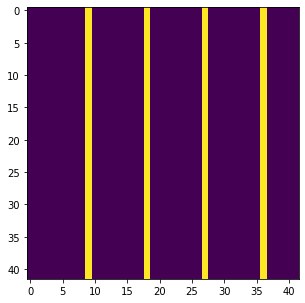

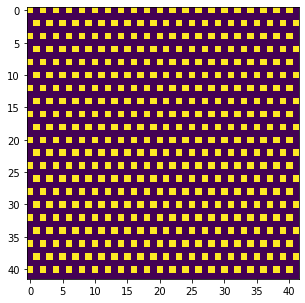

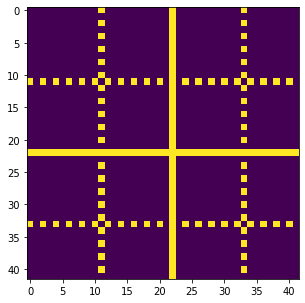

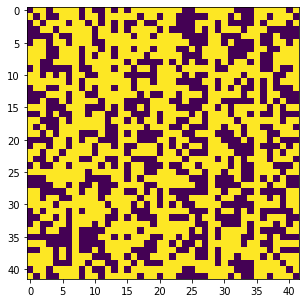

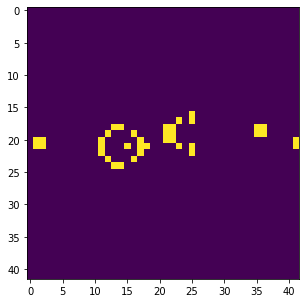

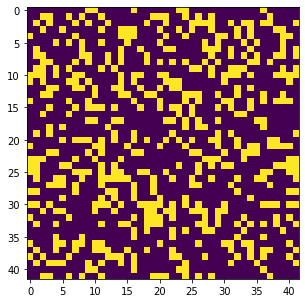

In [7]:
create_fields(40,40,0.3)
show_fields()

# (2) Provide a parallel implementation
# (3) Your parallel implementation runs for any number of MPI processors, regardless of the number of cells


In [9]:
%%writefile gameoflife.py
from mpi4py import MPI
import h5py
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from numba import njit
import argparse

parser = argparse.ArgumentParser('gameoflife')
parser.add_argument('-f', type = int, default = 0, help='frame')
flag = parser.parse_args()
flag = flag.f

comm = MPI.COMM_WORLD
n_proc = comm.Get_size()
rank = comm.Get_rank()

with h5py.File('Test/Next_grid.hdf5', 'r') as f:
    previous_field = f['array_0'][:]
    f.close()

W, H = previous_field.shape[0] - 2, previous_field.shape[1] - 2
w, h = previous_field.shape[0], previous_field.shape[1]

living_cells = np.sum(previous_field[1:w-1,1:h-1] == 1)

assert n_proc <= W, 'The number of processes lower than cells in current dimension'
X_size = W // n_proc

# def fillfield_part(field_size_y, field_size_x):
#     field_part = np.zeros([field_size_y, field_size_x])
#     field_part = np.random.randint(0, 2, (field_size_y, field_size_x))
#     field_part = np.pad(field_part, ((1,1),(1,1)))
#     return field_part

#@njit(fastmath=True)
def parallel_processing(current_field, next_field):
    alive = 1
    died = 0
    #next_field = deepcopy(current_field)
    W_loc, H_loc = current_field.shape[0], current_field.shape[1]    

    for x in range(1,H_loc-1): # go along x axis except borders
        for y in range(1,W_loc-1): # go along y axis except borders
            
            cell_type = current_field[y][x]
            count = -1 # don't count self
            # around current cell
            for j in range(y-1,y+2):
                for i in range(x-1,x+2):
                    # increase counter if find same cell
                    if current_field[j][i] == cell_type:
                        count += 1
            
            if current_field[y][x] == alive:
                if count == 2 or count == 3:
                    next_field[y][x] = current_field[y][x] # = alive - field won't change
                else:
                    next_field[y][x] = died # cell will die
            
            if current_field[y][x] == died:                
                if count == 5:
                    next_field[y][x] = alive # cell will alive
                else:
                    next_field[y][x] = current_field[y][x] # = died
                    
    return next_field

add_last = 0
if rank == n_proc - 1:
    if W % n_proc == 0:
        add_last = 0
    else:
        add_last = W % n_proc


# positions accorded to the ghost cells
start_x = X_size * rank
end_x = X_size * (rank + 1) + 2 + add_last

data = parallel_processing(previous_field[:,start_x:end_x], deepcopy(previous_field[:,start_x:end_x]))
data = comm.gather(data, root=0)

# if zero process =>
if rank == 0:
    out = [] # out array
    # for each process
    for i in range(n_proc):
        # cut the perimeter (ghost cells) and append into out[]
        a = data[i][1:data[i].shape[0]-1,1:data[i].shape[1]-1]
        out.append(a)
    out = np.concatenate((out), axis=1) # concatenate out array
    
    out = np.pad(out, ((1,1),(1,1))) # add padding

    # add ghost cells
    out[0, 0:H+2] = out[W, 0:H+2]
    out[W+1, 1:H+2] = out[1, 1:H+2]
    out[0:W+2, 0] = out[0:W+2, H] 
    out[0:W+2,H+1] = out[0:W+2, 1]
    with h5py.File('Test/Next_grid.hdf5', 'w') as f:
        f.create_dataset('array_0', data = out)
        f.close()

    plt.figure(figsize=(5, 5))
    plt.title('living_cells = ' + str(living_cells), fontsize=16)
    plt.imshow(out)
    #plt.savefig('Test/Game/Cond_0/Cond_0-'+str(flag))
    #plt.savefig('Test/Game/Cond_1/Cond_1-'+str(flag))
    plt.savefig('Test/Game/Cond_2/Cond_2-'+str(flag))
    #plt.savefig('Test/Game/Cond_3/Cond_3-'+str(flag))
    #plt.savefig('Test/Game/Cond_4/Cond_4-'+str(flag))
    #plt.savefig('Test/Game/Cond_5/Cond_5-'+str(flag))
    plt.close()
    print(living_cells)

Writing gameoflife.py


#(4) Run the game with the "Gosper's glider gun" initial condition
#(5) Model at least two more initial conditions
#(6) Plot the number of the living cells vs time for the three initial conditions above

**First condition**

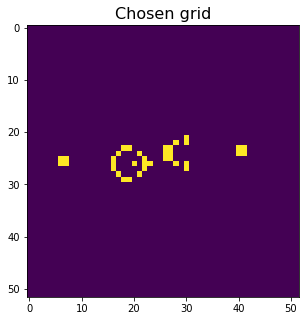

In [10]:
import subprocess
condition = 4
create_fields(W = 50, H = 50, life_cells = 0.1) # life_cells only for 5th condition
choose_grid(condition)

n_proc = 1
n_frames = 350
living = []
for i in range(0, n_frames, 1):
    a = subprocess.run(["mpiexec","--allow-run-as-root","-n", str(n_proc),"python", "gameoflife.py", '-f', str(i)],         
        universal_newlines=True,
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE)
    res = list(a.stdout.strip().split(' '))
    living.append(res[0])
    
living = list(map(float, living))
living

np.savez('Test/Game/Cond_'+str(condition)+'/Living_'+str(condition), living = living)

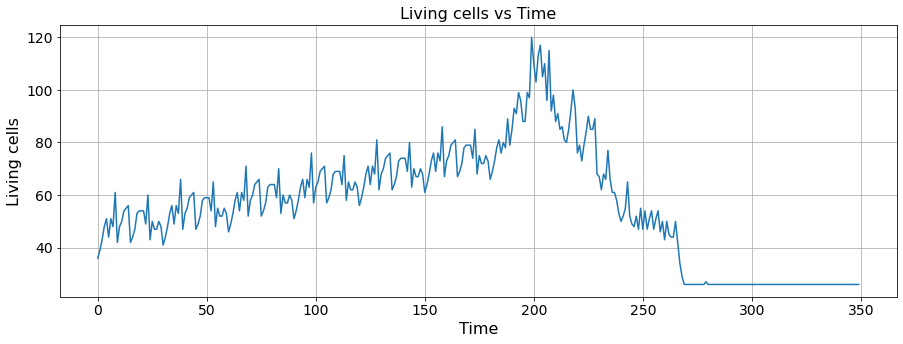

In [11]:
condition = 4
ex = np.load('Test/Game/Cond_'+str(condition)+'/Living_'+str(condition)+'.npz')
plt.figure(figsize=(15, 5))
plt.title('Living cells vs Time', fontsize=16)
plt.ylabel('Living cells', fontsize=16)
plt.xlabel('Time', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.plot(ex['living'])

**Second condition**

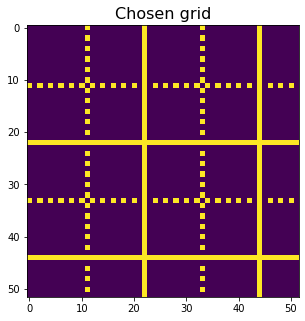

In [13]:
import subprocess
condition = 2
create_fields(W = 50, H = 50, life_cells = 0.1) # life_cells only for 5th condition
choose_grid(condition)

n_proc = 1
n_frames = 100
living = []
for i in range(0, n_frames, 1):
    a = subprocess.run(["mpiexec","--allow-run-as-root","-n", str(n_proc),"python", "gameoflife.py", '-f', str(i)],         
        universal_newlines=True,
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE)
    res = list(a.stdout.strip().split(' '))
    living.append(res[0])
    
living = list(map(float, living))
living

np.savez('Test/Game/Cond_'+str(condition)+'/Living_'+str(condition), living = living)

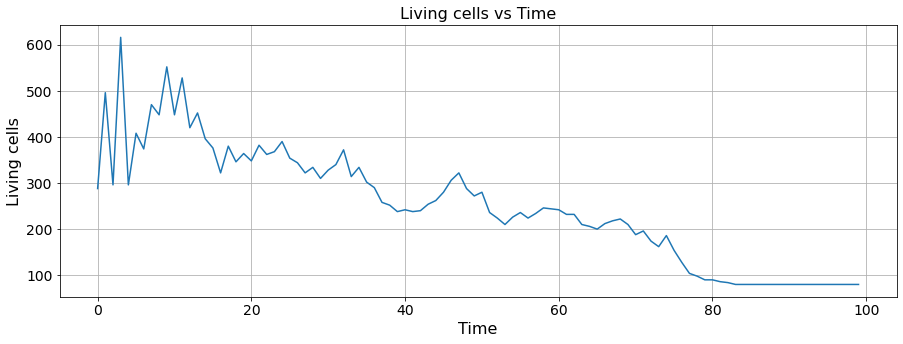

In [14]:
condition = 2
ex = np.load('Test/Game/Cond_'+str(condition)+'/Living_'+str(condition)+'.npz')
plt.figure(figsize=(15, 5))
plt.title('Living cells vs Time', fontsize=16)
plt.ylabel('Living cells', fontsize=16)
plt.xlabel('Time', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.plot(ex['living'])

**Third condition**

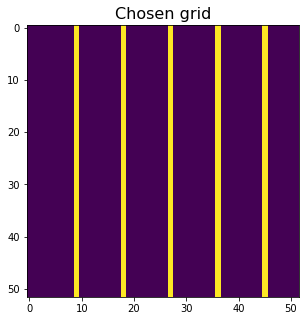

In [15]:
import subprocess
condition = 0
create_fields(W = 50, H = 50, life_cells = 0.1) # life_cells only for 5th condition
choose_grid(condition)

n_proc = 1
n_frames = 350
living = []
for i in range(0, n_frames, 1):
    a = subprocess.run(["mpiexec","--allow-run-as-root","-n", str(n_proc),"python", "gameoflife.py", '-f', str(i)],         
        universal_newlines=True,
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE)
    res = list(a.stdout.strip().split(' '))
    living.append(res[0])
    
living = list(map(float, living))
living

np.savez('Test/Game/Cond_'+str(condition)+'/Living_'+str(condition), living = living)

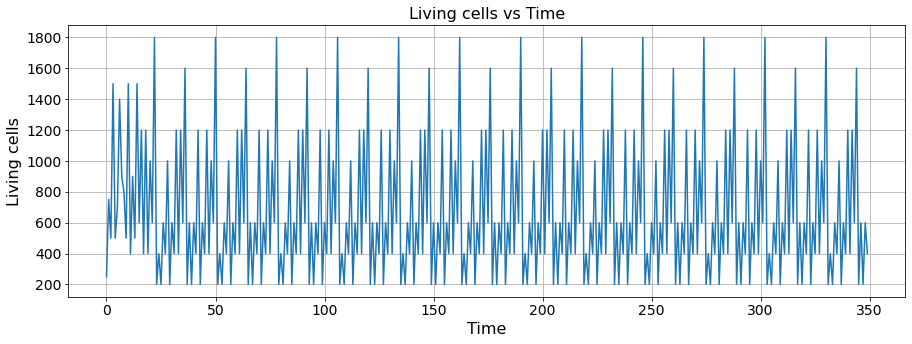

In [16]:
condition = 0
ex = np.load('Test/Game/Cond_'+str(condition)+'/Living_'+str(condition)+'.npz')
plt.figure(figsize=(15, 5))
plt.title('Living cells vs Time', fontsize=16)
plt.ylabel('Living cells', fontsize=16)
plt.xlabel('Time', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.plot(ex['living'])